# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [5]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer: 

PCA:
PCA finds vectors that explains the variance of the data. Since, we are looking at data from a wholesale grocery distributor, we would expect the first PCA dimension to be products that require daily delivery. This would include products like Milk, Fresh Food and Grocery. 

ICA:
For ICA, we would expect all the features to be included and thus would receive a matrix containing six features. ICA will return a matrix that consists of all the six features. In ICA, we're finding basis vectors that are statistically independent of the projected data. This will be used for creating a clear boundary such that the dimensions are not dependent on each other.

Thus, in our case our observables are nothing but the exports of different commodities and what we are trying to get (hidden variables) is the customer segments. Therefore we would expect commodities that are indepedendent of each other as our output features. This would help us in defining the clear boundary.

### PCA

      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
0 -0.976537 -0.121184 -0.061540 -0.152365          0.007054     -0.068105
1 -0.110614  0.515802  0.764606 -0.018723          0.365351      0.057079
2 -0.178557  0.509887 -0.275781  0.714200         -0.204410      0.283217
3 -0.041876 -0.645640  0.375460  0.646292          0.149380     -0.020396
4  0.015986  0.203236 -0.160292  0.220186          0.207930     -0.917077
5 -0.015763  0.033492  0.410939 -0.013289         -0.871284     -0.265417
-----------------------------------------
Variance Ratio of Individual Components
------------------------------------------
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


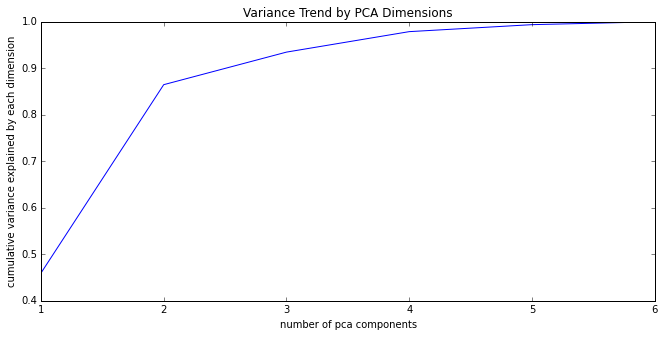

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 6)
pca.fit(data)

# prin the components and the variance of the data
print pd.DataFrame(pca.components_, columns = list(data.columns))
print "-----------------------------------------"
print "Variance Ratio of Individual Components"
print "------------------------------------------"
print pca.explained_variance_ratio_

plt.figure(figsize=(11,5))
plt.plot(np.arange(1,7),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of pca components")
plt.ylabel("cumulative variance explained by each dimension")
plt.title("Variance Trend by PCA Dimensions")


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: As seen from the graph above, most of the variance in the dataset is explained by the first two principal components. There seems to be a dip after two dimensions. At this point, we can see that graph begins to flatten. PCA emphasises on gaining more information  and minimizing loss of the same. Therefore, keeping in mind with the above graph, it would be appropriate to use 2 dimensions for explaining the variability of the dataset.

**3)** What do the dimensions seem to represent? How can you use this information?

Answer:
- The first principal component explains a major portion of Fresh Produce and a small portion of Milk and Frozen.
- The second principal component explains a major portion of Milk, Grocery, Detergents_Paper  and Delicatessen

The dimensions represent eigen vectors and the directions along the variation of the data. As seen from the lectures, PCA begins by converging to the center of the dataset and projects its axes along the spread of the data. Using the information as shown in the graph above, we find that the first two principal components explain almost 85-86% of the variability in the dataset.

This would mean that if we were to include only these two features in the training of the algorithm, we woud account for maximum coverage of the variablity in the dataset and not lose on much information.

PCA provides dimensionality reduction for visualisation of data and also to extract valuable information. It also make it possible for identifying latent features and make proper use of the data without increasing computation cost.

### ICA

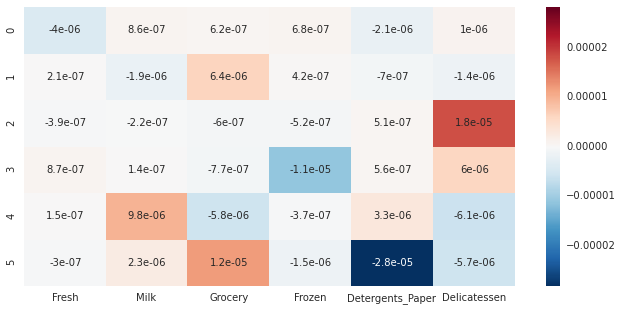

In [5]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
import seaborn as sns

# centering the data
centered = data.copy()
centered -= centered.mean()
ica = FastICA(n_components = 6)
ica.fit(centered)

#plotting heat map for better visulisation of matrix
plt.figure(figsize = (11,5))
sns.heatmap(pd.DataFrame(ica.components_,
                         columns = list(data.columns)),annot = True)



**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 
Looking at the heat map below we get the following conclusions:

- The first component of ICA primarily consists of Frozen and Delicatessen.
- The second component consists of Detergent_papers, Milk and Grocery.
- The third component consists of Milk, Grocery and Delicatessen.
- The fourth component consists of Fresh and Detergent paper.

The last two components are variable with the heat map showing values at either extreme. So, what does this matrix finally give us ? Let us understand this by looking at what ICA is responsible for:

ICA: Independent Component Analysis attempts to decompose a multivariate signal into independent non-gaussian signals. It is primarily used in signal processing.

It gives us a basis by which we can separate indepenedent features. The question now is why do we want statistically indepenedt features. When we decide to go ahead with clustering, it is quite important to have indepenedent features. This makes it possible to have a more visually sound boundary separting the customer segment.

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer:

Advantages of K-means clustering are as follows:

- Fast, robust and easier to understand.
- Relatively efficient: O(tknd), where n is # objects, k is # clusters, d is # dimension of each object, and t  is # iterations. Normally, k, t, d << n.
- Gives best result when data set are distinct or well separated from each other.

Advantages of Gaussian Mixture Models:

- The GMM algorithm is a good algorithm to use for the classification of static postures and non-temporal pattern recognition.
- fastest algorithm for learning mixture models



**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [6]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [10]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
reduced_data = PCA(n_components = 2).fit_transform(centered)
print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [31]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

#clusters = KMeans(n_clusters = 3).fit(reduced_data)
clusters = GMM(n_components = 2).fit(reduced_data)
print clusters

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)


In [32]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [33]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

# centroids = clusters.cluster_centers_
centroids = clusters.means_
print centroids

[[-10810.23008886   9858.15532401]
 [  3308.39301792  -3017.01739698]]


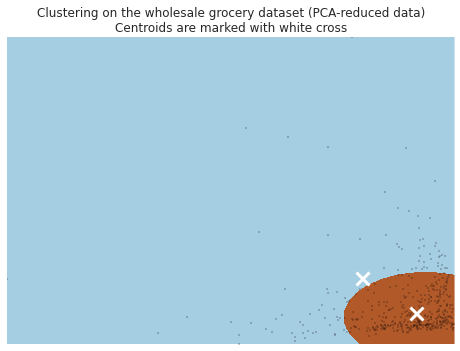

In [34]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 

We can see two distinct clustering of data. At the bottom right, we see that there is a close group of points. The wholesale grocery distributor distributes primarily to two different kind of customers. Large volume customer and small family run shops. Since, we received complaints from a large number of shops that are family run, delivering food products every evening becomes a problem. Thus, we find that there are two segments of customers and they are as shown in the graph above.

The bottom right cluster represents small family run shops whereas the high variable points represents large volume customers.


### Analysis of Three Clusters and beyond for GMM:

Figure below shows output for 3 clusters. As we can see there is no real boundary being created. It looks like there is a case of overfitting, as two cluster centers are very close to each other. In the case of creating customer segment, this would become a huge problem as we would be distinguishing cutomer segements based on a very fine boundary. Below is also a case of four clusters, where we overifit even worse

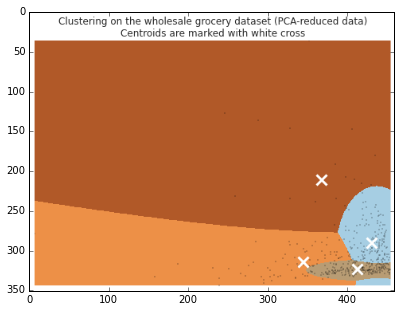

In [10]:
plt.figure(figsize = (11,5))
plt.imshow(mpimg.imread('threeclusters.png'))

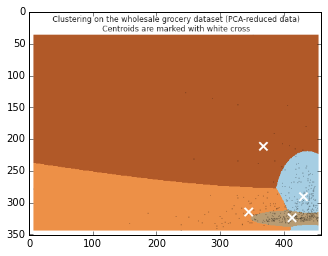

In [11]:
plt.imshow(mpimg.imread('fourclusters.png'))

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 

PCA along with GMM gave the best possible results. PCA helps us develop latent features and also reduces dimensions for better visualisation of data. Since, the given dataset contians only six features, PCA was still able to perform well and help reduce the data for visualisation. With the help of PCA, we were able to devise two primary principal components that best explained the variance in the dataset. We, then used the principal components to reduce the feature space to 2. This helped us primarily for visualisation of data. Now, with the results from feature transformation, we had two possible choices to cluster.

GMM provided better results from K-means, because it incorporated expectation-maximization (EM) algorithm for fitting mixture-of-Gaussian models. This is primarily useful when there is no clear divide of data. Grouping the data into clusters using GMM enables us to bucket the customers into their respective market segments and thus facilitates better business decision making.

**9)** How would you use that technique to help the company design new experiments?

Answer:

Now that we have two market segements, we can perform A/B tests in the respective segments. Thus, we can define our control and experiment group within the market segments without affecting the other segment. This is important as large volume customers might have better equipments and facilities to cater to cheaper evening delivery as compared to smaller family run businesses. If we do not segment the cutomers, one of the segments could overpower the other resulting in anomalous conclusions.

Since we now have different segments, we can perform the A/B test and calculate the p value for the resulting tests. If we were to find that we have a p-value greater than what we consider significant, we can go ahead and implement the change. Thus,we would have favourable results from the delivery experiments.

The company can use this technique to find segments of customers that purchase a certain kind of product, say frozen foods. They can then craft various marketing initiatives, such as a wholesale discount, to A/B test on the different segments and observe the impact. If a particular change shows promise, they can be implement to select segments thereby creating and catering to their market niches.

**10)** How would you use that data to help you predict future customer needs?

Answer: 

Now that we have defined the customer segments, we can run different tests to help increase profit, growth and supply of the products that caters to the particular segment. Suppose the high volume customers had profit figures along with growth potential, The company could ficus on strategies to better cater to their needs while avoiding to provide support to smaller business that do not give a good turnover.


We could also better sell products, if we know the demand of each segments. Also, using apriori algorithms we can employ market basket techniques to supplement sales of more products that go hand in hand with the current imports. All these predictions allows the company to be proactive in it's approach to better serve it's customers.

We could also potential feed this mode to a supervised model to predict the new customer in one of the segments given their import quantities. Thus we would expect future data to fall right in place with the clusters we have created. We can verify that our model is working this way. However, if most of the new points are outliers in our model, we would need to recompute.